In [1]:
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np
import pickle
import string
import re
 
%matplotlib inline

from __future__ import print_function
import nltk
import os



Define functions that will be used in the notebook:

In [2]:
# Setup nltk corpora path
nltk_path = os.sep.join([os.environ['HOME'], 'nltk_data'])
nltk.data.path.insert(0, nltk_path)

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(str(text)) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(str(token))
    stems = [str(stemmer.stem(t)) for t in filtered_tokens]
    return stems


def get_wordnet_pos(treebank_tag):
    """Convert the part-of-speech naming scheme
       from the nltk default to that which is
       recognized by the WordNet lemmatizer"""

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

    
def preprocess_series_text(data, nltk_path=nltk_path):
    """Perform complete preprocessing on a Pandas series
       including removal of alpha numerical words, normalization,
       punctuation removal, tokenization, stop word removal, 
       and lemmatization."""
    
    # remove alpha numerical words and make lowercase
    alphanum_re = re.compile(r"""\w*\d\w*""")
    alphanum_lambda = lambda x: alphanum_re.sub('', x.strip().lower())

    data = data.map(alphanum_lambda)

    # remove punctuation
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    punc_lambda = lambda x: punc_re.sub(' ', x)

    data = data.map(punc_lambda)

    # tokenize words
    data = data.map(word_tokenize)

    # remove stop words
    sw = stop_words
    #sw = stopwords.words('english')
    sw_lambda = lambda x: list(filter(lambda y: y not in sw, x))

    data = data.map(sw_lambda)

    # part of speech tagging--must convert to format used by lemmatizer
    data = data.map(nltk.pos_tag)
    pos_lambda = lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x]
    data = data.map(pos_lambda)

    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lem_lambda = lambda x: [lemmatizer.lemmatize(*y) for y in x]
    data = data.map(lem_lambda)
    
    
    return data

def bigram_gen(data):
    joined_bigrams = []
    for pair in list(nltk.bigrams(data)):
        joined_bigrams.append(' '.join(pair))
    return data+joined_bigrams

from gensim import corpora
def make_corpus(df, token_column_name, filter_above, filter_below):
    dictionary = corpora.Dictionary(df[token_column_name])
    dictionary.filter_extremes(filter_below, filter_above)
    corpus = [dictionary.doc2bow(text) for text in df[token_column_name]]
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))
    return dictionary, corpus

def get_doc_topic(corpus, model): 
    doc_topic = list() 
    for doc in corpus: 
        doc_topic.append(model.__getitem__(doc, eps=0)) 
    return doc_topic 

def get_topic_to_wordids(model): 
        p = list() 
        for topicid in range(model.num_topics): 
            topic = model.state.get_lambda()[topicid] 
            topic = topic / topic.sum() # normalize to probability dist 
            p.append(topic) 
        return p 


def get_game_in_groups(corpus, model, num_topics, df):
    group_prediction = get_doc_topic(corpus, model)
    keep = [[x[1] for x in document] for document in group_prediction] 
    column_list = ['topic '+ str(num) for num in range(num_topics)]
    df_group = pd.DataFrame([[x[1] for x in document] for document in group_prediction],columns=column_list)
    df_group['max_group'] = df_group.idxmax(axis =1)
    df_group['index1'] = df_group.index
    df['index1'] = df.index
    df_groups_names = pd.merge(df, df_group, on='index1')
    df_groups_predicted = df_groups_names.groupby('max_group')
    df_check = df_groups_predicted.aggregate(lambda x: tuple(x))
    df_check = df_check.reset_index()
    df_check = df_check[['max_group','name','index1']]
    games_categories = df_check['name']
    for groups in games_categories:
        print(groups) 
        print('\n')
        
    return df_groups_predicted, df_check

Import dataframe and stopwords: 

In [3]:
pkl_filename_master = "df_games.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    df_games = pickle.load(picklefile)

    
pkl_filename_master = "stop_words.pkl"
with open(pkl_filename_master, 'rb') as picklefile: 
    stop_words= pickle.load(picklefile)

Drop all data but the game descriptions and names:

In [4]:
test_df = df_games.copy().drop([ u'id', u'year_released', u'geek_rating', u'average_rating', 
       u'nrate', u'pic_url', u'url', u'index1', u'min_players', u'max_players', 
     u'category', u'attributes'], axis =1)

Process data, make single word tokens and single word tokens and bigrams to test:

In [5]:
test_df['tokens'] = preprocess_series_text(test_df['description'])

In [6]:
test_df['tokens_w_bigrams'] = test_df.apply(lambda row: bigram_gen(row['tokens']), axis = 1)

Next, make dictionary and corpus (document-term matrix) from tokens using the gensim package. The dictionary function assigns a unique id to each unique token across documents and counts the numbers of each. The dictionary is the key, value pairs of these ids and corresponding words. 
Then, the doc2bow converts each document (each token list in each row) to a bag of words, or a list of tuples containing the token identifier and the number of times it appears in the document (term id, term frequency). 

In [7]:
dictionary, corpus = make_corpus(test_df, 'tokens_w_bigrams', 0.5, 10)


Number of unique tokens: 2340
Number of documents: 1600


In [8]:
print(corpus[2])

[(3, 4), (8, 1), (32, 1), (114, 1), (115, 1), (125, 1), (144, 1), (149, 3), (173, 1), (316, 1), (323, 1), (352, 1), (391, 1), (400, 1), (401, 1), (441, 2), (450, 1), (474, 3), (486, 1), (513, 2), (545, 1), (579, 1), (642, 1), (650, 1), (682, 1), (788, 1), (793, 1), (858, 2), (956, 1), (1088, 1), (1185, 1), (1276, 1), (1302, 1), (1348, 1), (1395, 1), (1396, 1), (1404, 3), (1432, 1), (1451, 2), (1480, 1), (1489, 2), (1500, 1), (1523, 1), (1548, 1), (1562, 1), (1571, 1), (1598, 1), (1606, 1), (1616, 1), (1657, 1), (1720, 1), (1897, 1), (1918, 1), (1934, 1), (2026, 2), (2030, 1), (2048, 6), (2109, 1), (2177, 1), (2209, 1), (2218, 1), (2255, 3), (2291, 1)]


Use Ldamodel to cluster documents through topic modeling. LDA assumes that each document is a mixture of various topics and each topic uses each word with a different frequency. The frequency with which each document uses each word allows it to be grouped into a topic that uses those same words with a similar frequency.  The output of the LDA model is the most probable words to appear in each topic (cluster) and a measure of the frequency at which it appears in that topic (cluster):

In [17]:
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 10
iterations = 500
eval_every = None  # Model perplexity takes quite a lot of time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is to force Gensim to load the dictionary.
id2word = dictionary.id2token

model = LdaModel(corpus=corpus, id2word=id2word, 
                       chunksize=chunksize,
                       alpha='auto', 
                       eta='auto',
                       iterations=iterations, 
                       num_topics=num_topics,
                       passes=passes, 
                       eval_every=eval_every)

In [18]:
model_df = pd.DataFrame.from_records(model.show_topics(),columns=['Topic_Number','Word_frequency'])
model_df

,Topic_Number,Word_frequency
0,0,"0.013*""war"" + 0.010*""set"" + 0.009*""city"" + 0.0..."
1,1,"0.009*""train"" + 0.008*""civilization"" + 0.007*""..."
2,2,"0.013*""treasure"" + 0.010*""power"" + 0.009*""mons..."
3,3,"0.030*""tile"" + 0.016*""place"" + 0.011*""hand"" + ..."
4,4,"0.014*""hero"" + 0.012*""deck"" + 0.009*""world"" + ..."
5,5,"0.020*""action"" + 0.016*""round"" + 0.007*""place""..."
6,6,"0.011*""world"" + 0.010*""battle"" + 0.010*""power""..."
7,7,"0.018*""tile"" + 0.015*""build"" + 0.009*""worker"" ..."
8,8,"0.017*""piece"" + 0.013*""ship"" + 0.012*""move"" + ..."
9,9,"0.023*""building"" + 0.018*""build"" + 0.015*""dice..."


In [19]:
from pprint import pprint
top_topics = model.top_topics(corpus, num_words=10)
pprint(top_topics)

[([(0.030150833838657298, u'tile'),
   (0.01576121924817327, u'place'),
   (0.011344108607463705, u'hand'),
   (0.0095148844094383855, u'color'),
   (0.0095039295285348699, u'play'),
   (0.0083988445286836393, u'round'),
   (0.0078445363755590813, u'win'),
   (0.0078061675871361836, u'set'),
   (0.0070134885326002894, u'move'),
   (0.0069485486575560414, u'deck')],
  -58.670200500331205),
 ([(0.022914682346773223, u'building'),
   (0.018227206314011694, u'build'),
   (0.014587200363873792, u'dice'),
   (0.0095145557895344752, u'money'),
   (0.0092417806446151891, u'city'),
   (0.008618857043876077, u'resource'),
   (0.0078528282550556772, u'roll'),
   (0.007598887516789909, u'place'),
   (0.007531305566101076, u'round'),
   (0.0065104680373798537, u'action')],
  -62.32208423155366),
 ([(0.018382854453889024, u'tile'),
   (0.014556464202419057, u'build'),
   (0.0089533273150807693, u'worker'),
   (0.0084265338600386704, u'resource'),
   (0.0068309005214214711, u'space'),
   (0.006252659

This is a cool interactive tool to visualize LDA topics, whether you have independent clusters, and what words overlap between clusters: 

In [20]:
import pyLDAvis, pyLDAvis.gensim
from IPython.display import display

# Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

# Create the visualization
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

# Export as a standalone HTML web page
pyLDAvis.save_html(vis, 'lda.html')

# Let's view it!
display(vis)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      14.062545        1       1 -0.044722  0.020502
8      13.510489        1       2 -0.072696 -0.048758
4      13.464521        1       3  0.111184 -0.022294
3      12.463137        1       4 -0.096932 -0.057164
9      11.307262        1       5 -0.064336  0.047430
0       8.627515        1       6  0.065297  0.008674
7       8.213284        1       7 -0.027243  0.085677
6       7.590885        1       8  0.077675  0.012828
2       5.981331        1       9  0.032708 -0.071325
1       4.779032        1      10  0.019067  0.024429, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
728   Default  927.000000          tile  927.000000  30.0000  30.0000
1178  Default  556.000000      building  556.000000  29.0000  29.0000
2307  Default  456.000000         piece  456.000000  28.0000  28.0000
1479  Default  810.000000         build  810.000000  27.0000  27.0000
45    Default  321.000000          hero  321.000000  26.0000  26.0000
549   Default  382.000000           war  382.000000  25.0000  25.0000
819   Default  303.000000       monster  303.000000  24.0000  24.0000
940   Default  213.000000      treasure  213.000000  23.0000  23.0000
2325  Default  226.000000        worker  226.000000  22.0000  22.0000
615   Default  359.000000        battle  359.000000  21.0000  21.0000
1264  Default  785.000000        action  785.000000  20.0000  20.0000
645   Default  706.000000         round  706.000000  19.0000  19.0000
451   Default  192.000000      scenario  192.000000  18.0000  18.0000
1827  Default  497.000000         power  497.000000  17.0000  17.0000
2092  Default  177.000000       dungeon  177.000000  16.0000  16.0000
1077  Default  515.000000         world  515.000000  15.0000  15.0000
571   Default  417.000000          ship  417.000000  14.0000  14.0000
1910  Default  151.000000        animal  151.000000  13.0000  13.0000
955   Default  389.000000      resource  389.000000  12.0000  12.0000
987   Default  444.000000         color  444.000000  11.0000  11.0000
1706  Default  145.000000  civilization  145.000000  10.0000  10.0000
938   Default  513.000000          dice  513.000000   9.0000   9.0000
1874  Default  129.000000         train  129.000000   8.0000   8.0000
70    Default  184.000000          army  184.000000   7.0000   7.0000
358   Default  127.000000        pirate  127.000000   6.0000   6.0000
1716  Default   87.000000        zombie   87.000000   5.0000   5.0000
67    Default  174.000000          unit  174.000000   4.0000   4.0000
838   Default  889.000000         place  889.000000   3.0000   3.0000
1053  Default  327.000000         money  327.000000   2.0000   2.0000
841   Default  187.000000     adventure  187.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
488   Topic10   17.686394          hunt   58.551217   1.8438  -5.9136
1022  Topic10   23.949745        middle   82.796026   1.8005  -5.6104
1026  Topic10   26.707937    technology   99.710246   1.7236  -5.5014
1402  Topic10   26.288926         story  120.172245   1.5212  -5.5172
238   Topic10   10.046217        murder   32.175373   1.8769  -6.4792
1677  Topic10   26.365823         quest  125.619355   1.4797  -5.5143
24    Topic10   17.343703  investigator   72.363617   1.6125  -5.9332
1288  Topic10   17.977345       company   88.345832   1.4488  -5.8973
310   Topic10   18.027423         earth   89.955191   1.4335  -5.8945
733   Topic10   32.886257           map  257.868778   0.9815  -5.2933
1910  Topic10   23.187549        animal  151.891676   1.1614  -5.6428
1789  Topic10   26.562635           age  209.406596   0.9762  -5.5069
1814  Topic10   18.108191        knight  100.560980   1.3265  -5.8900
1188  Topic10   25.504775      original  201.733736   0.9728  -5.5475
1189  Topic10   28.

And what NLP/clustering project is complete without word clouds! 

0


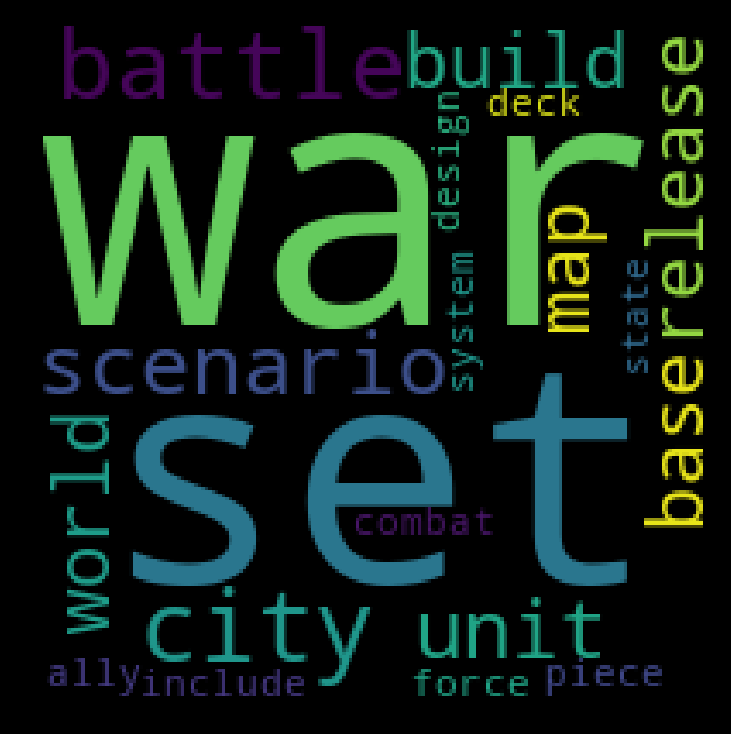

1


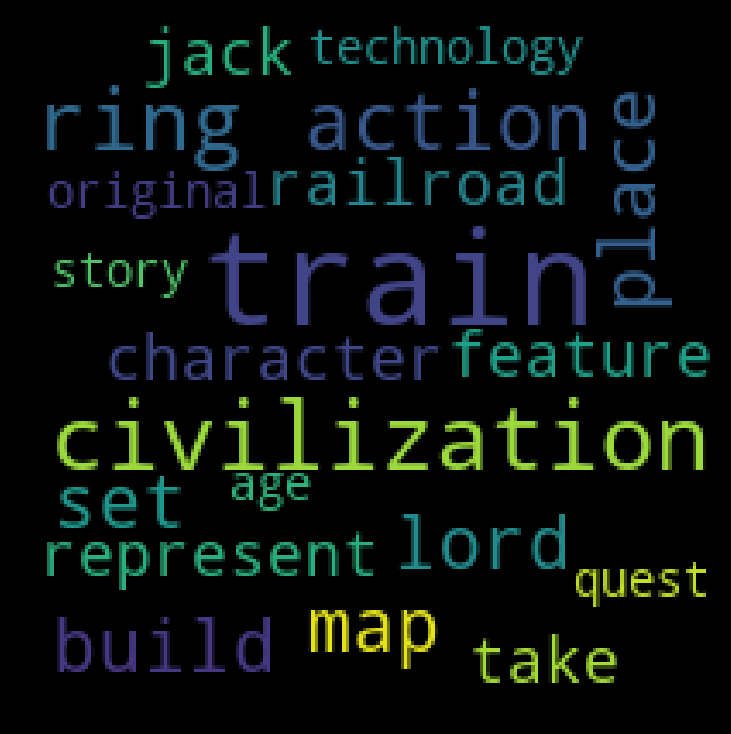

2


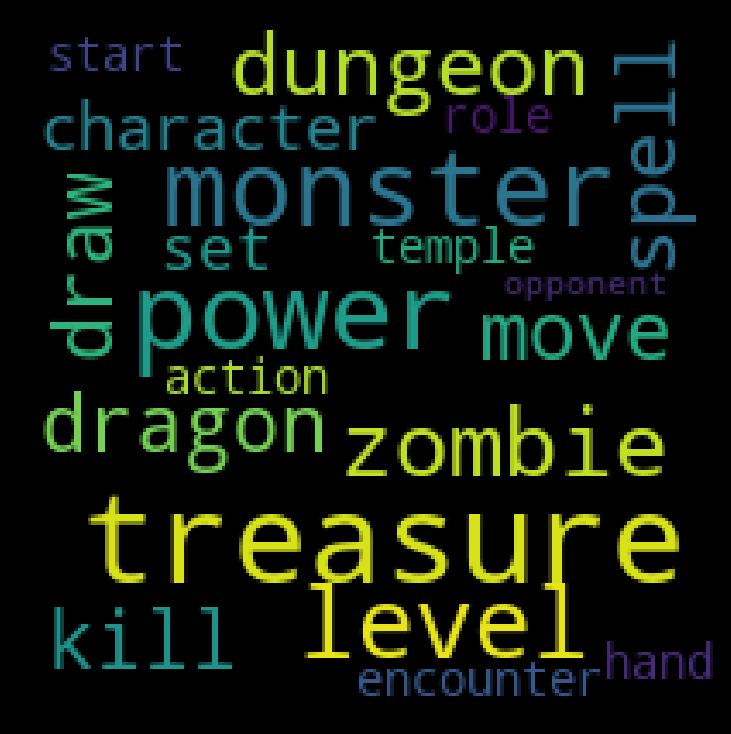

3


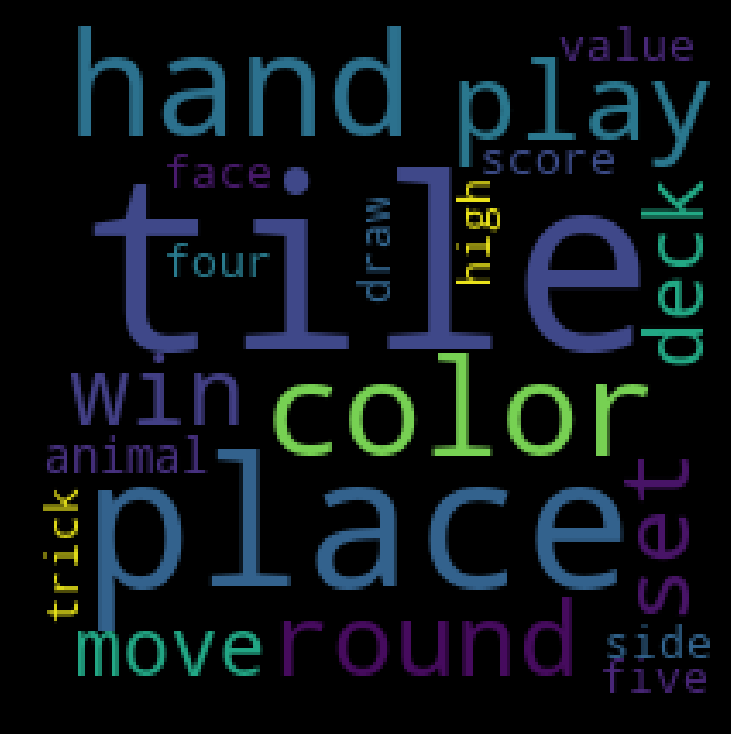

4


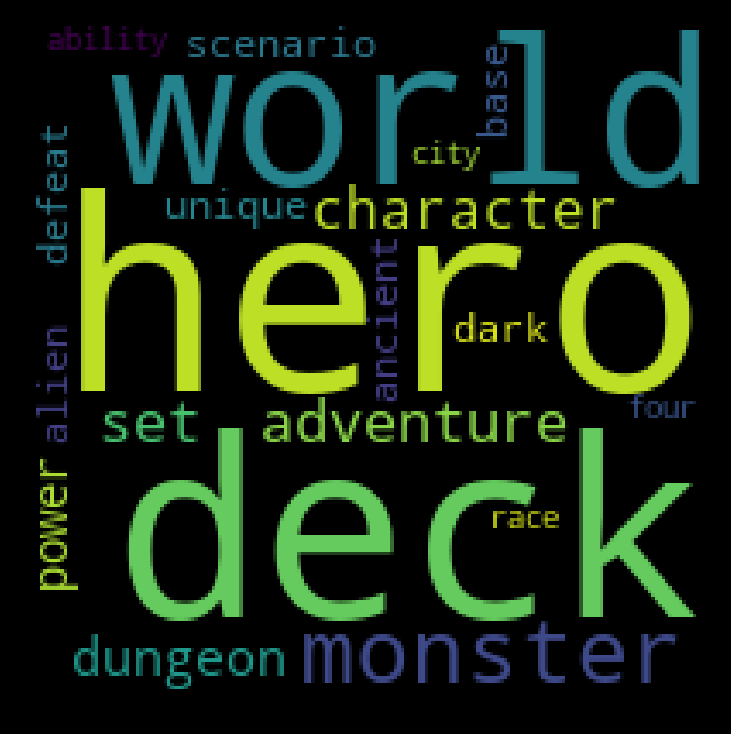

5


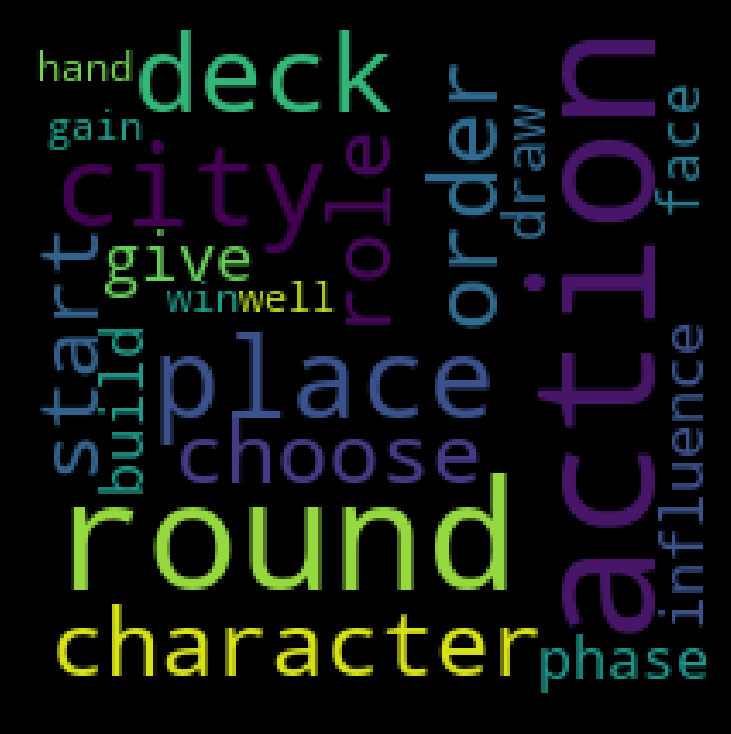

6


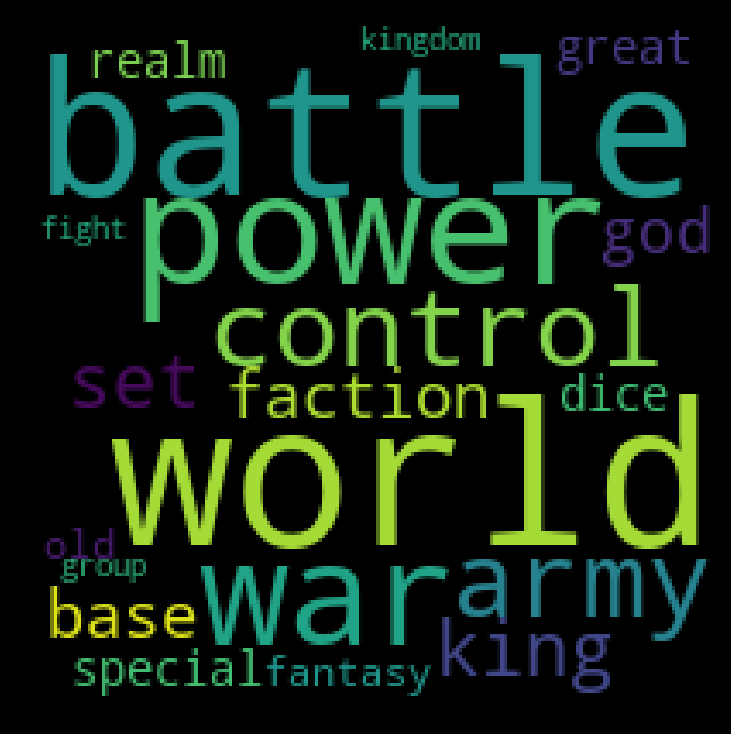

7


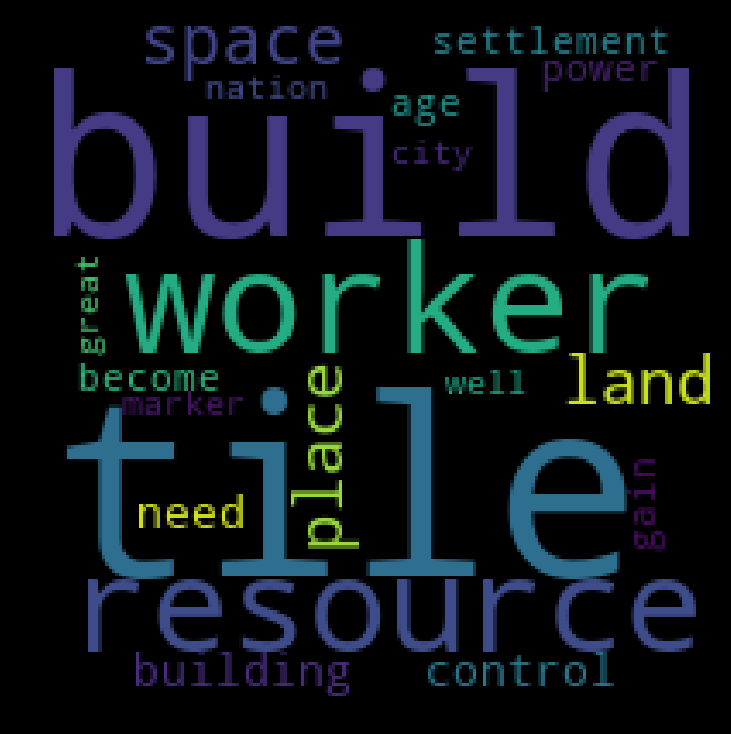

8


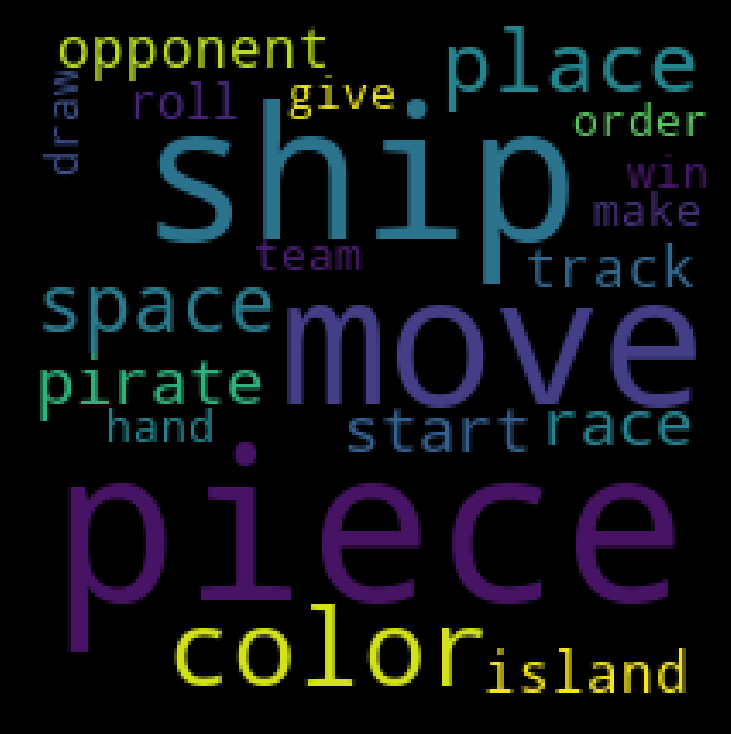

9


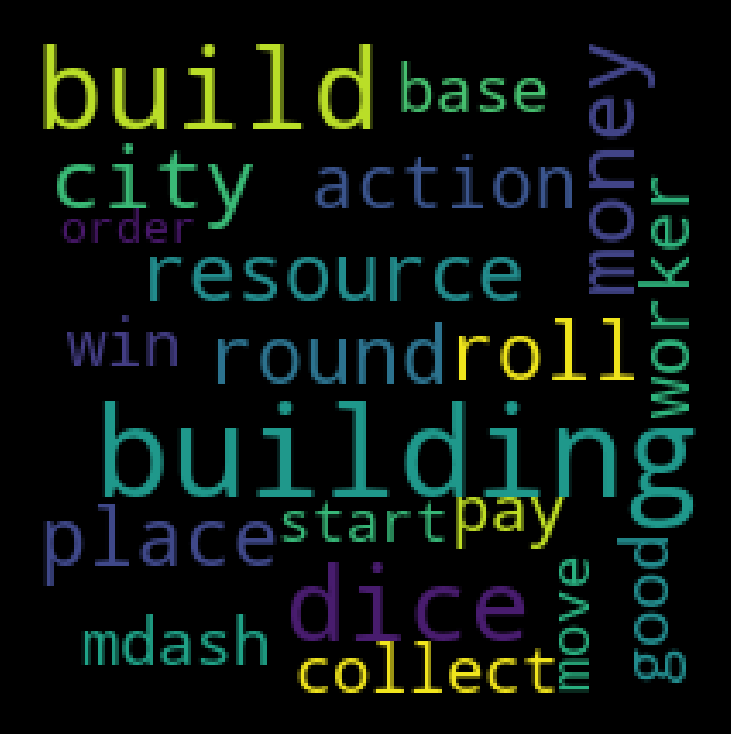

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for t in range(model.num_topics):
    
#     plt.figure()
#     plt.imshow(WordCloud().fit_words(dict(model.show_topic(t, 20))))    
#     plt.axis("off")
#     plt.title("Topic #" + str(t))
#     plt.show()


    print(t)
    wordcloud = WordCloud(width = 200,height = 200, background_color = "black").fit_words(dict(model.show_topic(t, 20)))  
    fig = plt.figure()
    # Instead of set_figwidth(30)
    fig.set_size_inches(20, fig.get_figheight(), forward=True)
    plt.figure( figsize=(20,10), facecolor='k')
    plt.title("Topic #" + str(t))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.tight_layout(pad=0)
    plt.show()
    

Knowing the topic clusters is great and all, but its only useful if I can get the game names out of the model to determine similarity and make recommendation.  
The function get_game_in_groups gets a measure of the amount of each topic cluster in each document and finds the most prevalent topic for each document (the maximum). It then traces each document back to the original game title and prints out all the games in each topic cluster.  It also returns a df with the measure of each topic in each document, and a dataframe with each topic, and the games in it.  

In [22]:
df_model, df_check = get_game_in_groups(corpus, model, num_topics, test_df)

(u'Twilight Struggle', u'Magic: The Gathering', u'Betrayal at House on the Hill', u'Chess', u"Memoir '44", u'Star Wars: X-Wing Miniatures Game', u'Scythe', u'Catan: Seafarers', u'Catan: 5-6 Player Extension', u'Star Wars: Imperial Assault', u'Shogun', u'Diplomacy', u'Neuroshima Hex!', u'Axis & Allies', u'Heroscape Master Set: Rise of the Valkyrie', u'Commands & Colors: Ancients', u'A Few Acres of Snow', u'Axis & Allies', u'Doom: The Boardgame', u'Wings of War: Famous Aces', u'Combat Commander: Europe', u'Hannibal: Rome vs. Carthage', u"Flick 'em Up!", u'The Rivals for Catan', u'Paths of Glory', u'BattleLore (Second Edition)', u'Tide of Iron', u'Struggle of Empires', u'Hammer of the Scots', u'Wallenstein (first edition)', u'Battle Cry', u'Catan: Seafarers \u2013 5-6 Player Extension', u'Stronghold', u'Catan: Cities & Knights \u2013 5-6 Player Extension', u'D-Day Dice', u'Steampunk Rally', u'Elasund: The First City', u'Advanced Squad Leader', u'Here I Stand', u'Catan: Traders & Barbarian

In [23]:
df_model.head(3)

,name,description,tokens,tokens_w_bigrams,index1,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,max_group
0,Catan,"In Catan (formerly The Settlers of Catan), pla...","[formerly, settler, dominant, force, island, b...","[formerly, settler, dominant, force, island, b...",0,0.000221,0.000197,0.000205,0.240637,0.000278,0.000309,0.000228,0.190574,0.000302,0.567048,topic 9
1,Carcassonne,Carcassonne is a tile-placement game in which ...,"[tile, placement, draw, place, tile, piece, so...","[tile, placement, draw, place, tile, piece, so...",1,0.000506,0.000451,0.000471,0.833424,0.000638,0.136114,0.000523,0.026581,0.000692,0.000600,topic 3
2,Pandemic,"In Pandemic, several virulent diseases have br...","[several, virulent, disease, break, simultaneo...","[several, virulent, disease, break, simultaneo...",2,0.000459,0.000409,0.000427,0.000605,0.000578,0.995420,0.000474,0.000458,0.000628,0.000544,topic 5
3,Dominion,(from the back of the box:)&#10;&#10;&quot;You...,"[back, box, monarch, like, parent, ruler, plea...","[back, box, monarch, like, parent, ruler, plea...",3,0.000443,0.000395,0.000412,0.000584,0.000558,0.995576,0.000458,0.000442,0.000606,0.000525,topic 5
4,7 Wonders,You are the leader of one of the 7 great citie...,"[leader, great, city, ancient, world, gather, ...","[leader, great, city, ancient, world, gather, ...",4,0.000361,0.000322,0.000336,0.000477,0.000455,0.000506,0.000373,0.584916,0.000494,0.411759,topic 7
5,Ticket to Ride,"With elegantly simple gameplay, Ticket to Ride...","[elegantly, simple, gameplay, learn, minute, p...","[elegantly, simple, gameplay, learn, minute, p...",5,0.000398,0.102652,0.000370,0.000525,0.000502,0.893727,0.000411,0.000397,0.000545,0.000472,topic 5
8,Small World,"In Small World, players vie for conquest and c...","[world, vie, conquest, control, world, simply,...","[world, vie, conquest, control, world, simply,...",8,0.000382,0.000341,0.000356,0.131626,0.000482,0.000536,0.864918,0.000382,0.000523,0.000454,topic 6
9,Power Grid,Power Grid is the updated release of the Fried...,"[power, grid, update, release, friedemann, fri...","[power, grid, update, release, friedemann, fri...",9,0.000406,0.000362,0.517291,0.000536,0.000512,0.279602,0.000420,0.199834,0.000556,0.000482,topic 2
10,Citadels,"In Citadels, players take on new roles each ro...","[citadel, role, round, represent, character, h...","[citadel, role, round, represent, character, h...",10,0.000300,0.000268,0.000280,0.000396,0.000379,0.000421,0.000310,0.000300,0.000411,0.996936,topic 9
11,King of Tokyo,"In King of Tokyo, you play mutant monsters, gi...","[king, tokyo, mutant, monster, gigantic, robot...","[king, tokyo, mutant, monster, gigantic, robot...",11,0.000627,0.000559,0.000584,0.000828,0.505670,0.000879,0.000648,0.072257,0.000859,0.417089,topic 4


In [24]:
df_check.head(12)

,max_group,name,index1
0,topic 0,"(Twilight Struggle, Magic: The Gathering, Betr...","(23, 33, 35, 44, 51, 69, 81, 127, 144, 149, 16..."
1,topic 1,"(Ticket to Ride: Europe, Lords of Waterdeep, S...","(13, 20, 43, 46, 133, 134, 137, 143, 153, 191,..."
2,topic 2,"(Power Grid, Munchkin, BANG!, Tikal, Zombies!!...","(9, 21, 48, 103, 117, 120, 140, 142, 151, 156,..."
3,topic 3,"(Carcassonne, Bohnanza, Lost Cities, Tigris & ...","(1, 22, 25, 45, 66, 72, 74, 82, 94, 100, 107, ..."
4,topic 4,"(King of Tokyo, Arkham Horror, Battlestar Gala...","(11, 17, 27, 32, 54, 60, 61, 71, 80, 88, 89, 9..."
5,topic 5,"(Pandemic, Dominion, Ticket to Ride, Agricola,...","(2, 3, 5, 6, 7, 14, 16, 19, 26, 31, 38, 42, 58..."
6,topic 6,"(Small World, Terra Mystica, Risk, Android: Ne...","(8, 29, 34, 41, 57, 63, 67, 73, 104, 148, 172,..."
7,topic 7,"(7 Wonders, Love Letter, The Castles of Burgun...","(4, 12, 28, 47, 62, 77, 79, 90, 106, 109, 115,..."
8,topic 8,"(Dixit, Codenames, Forbidden Island, Hanabi, G...","(15, 18, 24, 30, 39, 50, 56, 64, 68, 83, 96, 1..."
9,topic 9,"(Catan, Citadels, Caylus, Alhambra, 7 Wonders ...","(0, 10, 36, 37, 40, 49, 52, 53, 55, 75, 76, 84..."


Try the HDP model to see if I can get a better estimate of how many clusters I should have:

In [ ]:
hdp = HdpModel(corpus, id2word)
doc_hdp = hdp[doc_bow]